In [5]:
# Temel
import warnings, re, string, pickle, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

# Metin işleme
import demoji, contractions, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException

# Veri bölme & etiket
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Oversampling
from imblearn.over_sampling import SMOTE

# Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Görselleştirme
import seaborn as sns, matplotlib.pyplot as plt

# NLTK setup
nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)
stop_words  = set(stopwords.words("english"))
lemmatizer  = WordNetLemmatizer()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 256)       │       253,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_attention                │ (None, 256)            │             0 │
│ (SimpleAttention)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,294,982 (16.38 MB)

 Trainable params: 4,294,982 (16.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
261/261 - 116s - 445ms/step - accuracy: 0.6356 - loss: 0.8737 - val_accuracy: 0.8205 - val_loss: 0.4382
Epoch 2/10
261/261 - 93s - 357ms/step - accuracy: 0.7818 - loss: 0.5289 - val_accuracy: 0.8334 - val_loss: 0.4076
Epoch 3/10
261/261 - 96s - 368ms/step - accuracy: 0.8196 - loss: 0.4414 - val_accuracy: 0.8501 - val_loss: 0.3797
Epoch 4/10
261/261 - 96s - 367ms/step - accuracy: 0.8547 - loss: 0.3622 - val_accuracy: 0.8492 - val_loss: 0.4055
Epoch 5/10
261/261 - 97s - 373ms/step - accuracy: 0.8880 - loss: 0.2885 - val_accuracy: 0.8468 - val_loss: 0.4387
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step

✅ Test Accuracy: 0.8501

                     precision    recall  f1-score   support

                age       0.97      0.98      0.98      1369
          ethnicity       0.98      0.98      0.98      1303
             gender       0.88      0.84      0.86      1280
  not_cyberbullying       0.66      0.47      0.55      1061
other_cyberbullying       0.55      0.75      0.63     

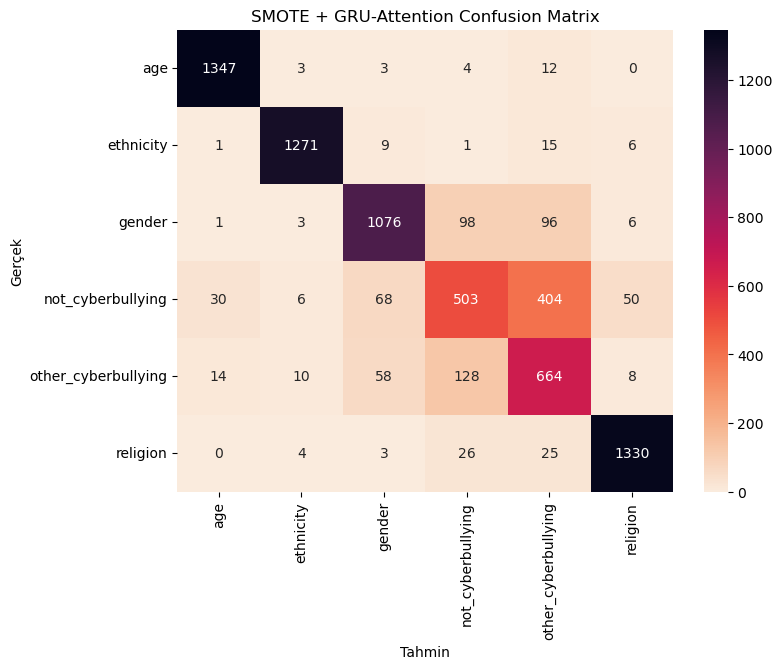

🎉 Model ve tokenizer kaydedildi.


In [6]:
### 1) Temizleme Fonksiyonları
def remove_emoji(t):              return demoji.replace(t, "")
def expand_contractions(t):       return contractions.fix(t)
def remove_non_english(t):
    try:  return t if detect(t) == "en" else ""
    except LangDetectException: return ""
def remove_all_entities(t):
    t = re.sub(r"[\r\n]+", " ", t.lower())
    t = re.sub(r"(?:@|https?://)\S+", "", t)
    t = t.translate(str.maketrans('', '', string.punctuation))
    return " ".join(w for w in t.split() if w not in stop_words)
def lemmatize(t):                 return " ".join(lemmatizer.lemmatize(w) for w in t.split())
def remove_short(t, n=2):         return " ".join(w for w in t.split() if len(w) >= n)
def correct_elong(t):             return re.sub(r"\b(\w+?)((\w)\3{2,})(\w*)\b", r"\1\3\4", t)
def clean(t):
    t = remove_emoji(t); t = expand_contractions(t); t = remove_non_english(t)
    t = remove_all_entities(t); t = lemmatize(t); t = remove_short(t); t = correct_elong(t)
    return " ".join(t.split())

### 2) Veri Yükle & Temizle
df = pd.read_csv("dataset.csv")
df["text_clean"] = df["tweet_text"].astype(str).apply(clean)
df = df[df["text_clean"].str.strip() != ""].drop_duplicates("text_clean")
df = df[df["text_clean"].str.split().str.len() >= 3]

labeler = LabelEncoder(); df["label"] = labeler.fit_transform(df["cyberbullying_type"])

X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

### 3) Tokenizer & Padding
MAX_WORDS, MAX_LEN = 20000, 100
tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>"); tok.fit_on_texts(X_train)

X_tr_pad = pad_sequences(tok.texts_to_sequences(X_train), maxlen=MAX_LEN, padding="post")
X_te_pad = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=MAX_LEN, padding="post")

### 4) SMOTE Oversampling (yinelenen embedding vektörü yerine diziler)
sm = SMOTE(random_state=42, k_neighbors=3)
X_tr_overs, y_tr_overs = sm.fit_resample(X_tr_pad, y_train)

### 5) Class Weights
cls_w = compute_class_weight("balanced", classes=np.unique(y_tr_overs), y=y_tr_overs)
class_weight = dict(zip(np.unique(y_tr_overs), cls_w))

### 6) Embedding Matrix (GloVe 200d)
EMB_DIM = 200
emb_index = {}
with open("glove.6B.200d.txt", encoding="utf8") as f:
    for line in f:
        w,*vec = line.split(); emb_index[w] = np.asarray(vec, dtype="float32")
num_words = min(MAX_WORDS, len(tok.word_index)+1)
emb_mat = np.zeros((num_words, EMB_DIM))
for w,i in tok.word_index.items():
    if i < MAX_WORDS and w in emb_index: emb_mat[i] = emb_index[w]

### 7) Basit Attention Layer
class SimpleAttention(Layer):
    def call(self, inputs):
        # inputs: (batch, timesteps, hidden)
        score = tf.nn.softmax(tf.reduce_sum(inputs, axis=2, keepdims=True), axis=1)
        context = tf.reduce_sum(inputs * score, axis=1)
        return context

### 8) Model
inp = Input(shape=(MAX_LEN,))
x = Embedding(num_words, EMB_DIM, weights=[emb_mat], input_length=MAX_LEN, trainable=True)(inp)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = SimpleAttention()(x)
x = Dense(128, activation="relu")(x); x = Dropout(0.3)(x)
x = Dense(64,  activation="relu")(x)
out = Dense(len(labeler.classes_), activation="softmax")(x)
model = Model(inp, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

### 9) Eğitim
y_tr_cat = to_categorical(y_tr_overs, num_classes=len(labeler.classes_))
y_te_cat = to_categorical(y_test,     num_classes=len(labeler.classes_))
model.fit(
    X_tr_overs, y_tr_cat,
    validation_data=(X_te_pad, y_te_cat),
    epochs=10, batch_size=128,
    class_weight=class_weight,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=2
)

### 10) Değerlendirme
probs = model.predict(X_te_pad); y_pred = probs.argmax(1)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred, target_names=labeler.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket_r",
            xticklabels=labeler.classes_, yticklabels=labeler.classes_)
plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.title("SMOTE + GRU-Attention Confusion Matrix")
plt.show()

### 11) Kaydet
model.save("smote_gru_attention_model.h5")
with open("tokenizer.pkl", "wb") as f: pickle.dump(tok, f)
print("🎉 Model ve tokenizer kaydedildi.")


In [7]:
# ── Temel ──────────────────────────────────────────────────────────────
import warnings, re, string, pickle, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

# ── Metin işleme ───────────────────────────────────────────────────────
import demoji, contractions, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException

# ── Veri & etiket ──────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report,
                             confusion_matrix, accuracy_score)

# ── Oversampling ───────────────────────────────────────────────────────
from imblearn.over_sampling import SMOTE

# ── TensorFlow / Keras ─────────────────────────────────────────────────
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Embedding, Conv1D,
                                     GlobalMaxPooling1D, Bidirectional,
                                     GRU, Dense, Dropout, Layer,
                                     LayerNormalization, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# ── Görselleştirme ─────────────────────────────────────────────────────
import seaborn as sns, matplotlib.pyplot as plt

# ── NLTK setup ─────────────────────────────────────────────────────────
nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)
stop_words  = set(stopwords.words("english"))
lemmatizer  = WordNetLemmatizer()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 200)  │  4,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 200)  │        400 │ embedding_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 128)   │     76,928 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 128)   │    102,528 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 128)   │    128,128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 100, 256)  │    253,440 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_attention_1  │ (None, 256)       │          0 │ bidirectional_2[… │
│ (SimpleAttention)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 640)       │          0 │ concatenate[0][0… │
│ (Concatenate)       │                   │            │ simple_attention… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     82,048 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 6)         │        390 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,652,118 (17.75 MB)

 Trainable params: 4,652,118 (17.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
261/261 - 172s - 659ms/step - accuracy: 0.6881 - loss: 0.1574 - val_accuracy: 0.8275 - val_loss: 0.1076
Epoch 2/10
261/261 - 168s - 642ms/step - accuracy: 0.7908 - loss: 0.1184 - val_accuracy: 0.8492 - val_loss: 0.1006
Epoch 3/10
261/261 - 162s - 620ms/step - accuracy: 0.8347 - loss: 0.1045 - val_accuracy: 0.8485 - val_loss: 0.1037
Epoch 4/10
261/261 - 158s - 607ms/step - accuracy: 0.8841 - loss: 0.0924 - val_accuracy: 0.8397 - val_loss: 0.1087
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step

✅ Test Accuracy: 0.8492

                     precision    recall  f1-score   support

                age       0.98      0.97      0.98      1368
          ethnicity       0.98      0.97      0.97      1302
             gender       0.89      0.86      0.88      1280
  not_cyberbullying       0.60      0.63      0.62      1060
other_cyberbullying       0.53      0.56      0.55       883
           religion       0.97      0.96      0.96      1388

           accuracy                       

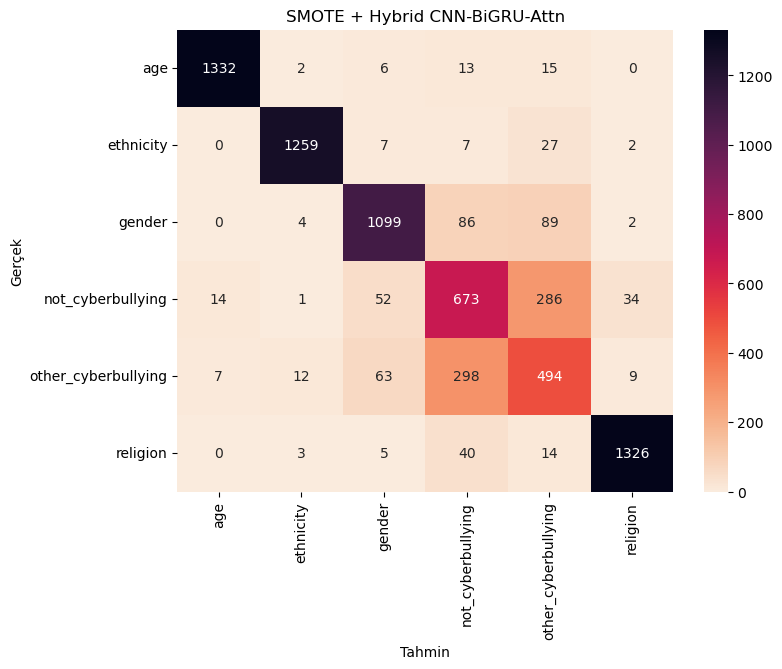

🎉 Model ve tokenizer kaydedildi.


In [8]:
# 1) Gerekli kütüphaneler
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utils import final_clean, AttentionLayer
from sklearn.metrics import classification_report, accuracy_score

df_test = pd.read_csv("test.csv")

# 3) Metinleri aynı şekilde temizle
df_test["text_clean"] = df_test["tweet_text"].astype(str).apply(final_clean)

label_map = {
    "age": 0,
    "ethnicity": 1,
    "gender": 2,
    "not_cyberbullying": 3,
    "other_cyberbullying": 4,
    "religion": 5
}
y_true = df_test["cyberbullying_type"].map(label_map).values

# 5) Model ve tokenizer’ı yükle
model = load_model(
    "gruudene_attention_model.h5",
    custom_objects={'AttentionLayer': AttentionLayer}
)
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# 6) Test metinlerini tokenize + pad et
MAXLEN = 100  
seqs = tokenizer.texts_to_sequences(df_test["text_clean"])
X_test_pad = pad_sequences(seqs, maxlen=MAXLEN, padding="post", truncating="post")

# 7) Tahmin et ve y_pred oluştur
probs = model.predict(X_test_pad, batch_size=128, verbose=1)
y_pred = probs.argmax(axis=1)

# 8) Performans metrikleri
acc = accuracy_score(y_true, y_pred)
print(f"✅ Test set accuracy: {acc:.4f}\n")

print("📋 Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=list(label_map.keys()),
    digits=4
))

# 9) Confusion Matrix ve Görselleştirme

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Etiket isimleri (label_map’in tersini alabilir veya doğrudan le.classes_ kullanabilirsin)
labels = ["age","ethnicity","gender","not_cyberbullying","other_cyberbullying","religion"]

# 1️⃣ Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# 2️⃣ Matrisin metin çıktısı
print("Confusion Matrix (satırlar = gerçek, sütunlar = tahmin):\n")
print(pd.DataFrame(cm, index=labels, columns=labels))

# 3️⃣ Isı haritası çizimi
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket_r",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix Heatmap")
plt.show()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ word_ids            │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 200)  │  4,000,000 │ word_ids[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pos_encoding_1      │ (None, 100, 200)  │          0 │ embedding_4[0][0] │
│ (PosEncoding)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 200)  │    642,600 │ pos_encoding_1[0… │
│ (MultiHeadAttentio… │                   │            │ pos_encoding_1[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 200)  │          0 │ pos_encoding_1[0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 200)  │        400 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 100, 256)  │     51,456 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 256)  │        512 │ dense_6[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 100, 200)  │     51,400 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_ids            │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 200)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 300, 64)   │      6,144 │ char_ids[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 200)  │        400 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 296, 128)  │     41,088 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 200)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 328)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     84,224 │ concatenate_2[0]

 Total params: 4,911,894 (18.74 MB)

 Trainable params: 4,911,894 (18.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
261/261 - 235s - 900ms/step - accuracy: 0.7351 - loss: 0.6598 - val_accuracy: 0.8334 - val_loss: 0.4016
Epoch 2/10
261/261 - 226s - 867ms/step - accuracy: 0.8378 - loss: 0.4130 - val_accuracy: 0.8379 - val_loss: 0.4014
Epoch 3/10
261/261 - 227s - 868ms/step - accuracy: 0.8702 - loss: 0.3472 - val_accuracy: 0.8486 - val_loss: 0.4047
Epoch 4/10
261/261 - 227s - 869ms/step - accuracy: 0.9000 - loss: 0.2808 - val_accuracy: 0.8532 - val_loss: 0.3942
Epoch 5/10
261/261 - 226s - 867ms/step - accuracy: 0.9213 - loss: 0.2217 - val_accuracy: 0.8519 - val_loss: 0.4139
Epoch 6/10
261/261 - 232s - 890ms/step - accuracy: 0.9347 - loss: 0.1884 - val_accuracy: 0.8493 - val_loss: 0.4898
228/228 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step

✅ Test Accuracy: 0.8532

                     precision    recall  f1-score   support

                age       0.99      0.97      0.98      1370
          ethnicity       0.98      0.98      0.98      1305
             gender       0.87      0.86      0.86      1

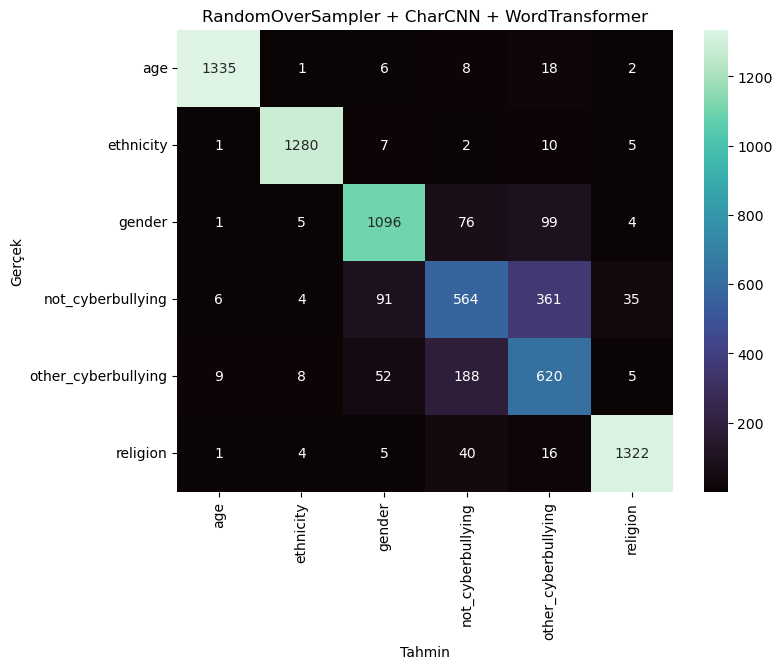

🎉 Model ve tokenizer kaydedildi.


In [11]:
# ------------------------------------------------------------------
# 0) İMPORT’LAR
# ------------------------------------------------------------------
import warnings, re, string, pickle, numpy as np, pandas as pd
warnings.filterwarnings("ignore")

import demoji, contractions, nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report,
                             confusion_matrix, accuracy_score)

from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Embedding, Conv1D,
                                     GlobalMaxPooling1D, MultiHeadAttention,
                                     Dense, Dropout, LayerNormalization,
                                     Concatenate, Layer)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns, matplotlib.pyplot as plt

nltk.download("wordnet", quiet=True)
nltk.download("stopwords", quiet=True)
stop_words  = set(stopwords.words("english"))
lemmatizer  = WordNetLemmatizer()

# ------------------------------------------------------------------
# 1) TEMİZLEME
# ------------------------------------------------------------------
def remove_emoji(t):         return demoji.replace(t, "")
def expand_contractions(t):  return contractions.fix(t)
def remove_non_english(t):
    try:  return t if detect(t) == "en" else ""
    except LangDetectException: return ""
def remove_all_entities(t):
    t = re.sub(r"[\r\n]+", " ", t.lower())
    t = re.sub(r"(?:@|https?://)\S+", "", t)
    t = t.translate(str.maketrans('', '', string.punctuation))
    return " ".join(w for w in t.split() if w not in stop_words)
def lemmatize(t):            return " ".join(lemmatizer.lemmatize(w) for w in t.split())
def remove_short(t, n=2):    return " ".join(w for w in t.split() if len(w) >= n)
def correct_elong(t):        return re.sub(r"\b(\w+?)((\w)\3{2,})(\w*)\b", r"\1\3\4", t)
def clean(t):
    t = remove_emoji(t); t = expand_contractions(t); t = remove_non_english(t)
    t = remove_all_entities(t); t = lemmatize(t); t = remove_short(t); t = correct_elong(t)
    return " ".join(t.split())

# ------------------------------------------------------------------
# 2) VERİ
# ------------------------------------------------------------------
df = pd.read_csv("dataset.csv")
df["text_clean"] = df["tweet_text"].astype(str).apply(clean)
df = df[df["text_clean"].str.strip() != ""].drop_duplicates("text_clean")
df = df[df["text_clean"].str.split().str.len() >= 3]

labeler = LabelEncoder()
df["label"] = labeler.fit_transform(df["cyberbullying_type"])

X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"], df["label"], test_size=0.2,
    stratify=df["label"], random_state=42
)

# ------------------------------------------------------------------
# 3) WORD TOKENIZER & PAD
# ------------------------------------------------------------------
MAX_WORDS, MAX_LEN = 20000, 100
w_tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
w_tok.fit_on_texts(X_train)
X_tr_word = pad_sequences(w_tok.texts_to_sequences(X_train), MAX_LEN, padding='post')
X_te_word = pad_sequences(w_tok.texts_to_sequences(X_test),  MAX_LEN, padding='post')

# ------------------------------------------------------------------
# 4) CHAR DİZİLEŞTİRME
# ------------------------------------------------------------------
CHAR_VOCAB = ['<PAD>'] + [chr(i) for i in range(32,127)]
char2id = {c:i for i,c in enumerate(CHAR_VOCAB)}
MAX_CHAR = 300

def char_encode(s):
    s = s[:MAX_CHAR].ljust(MAX_CHAR)
    return [char2id.get(c, 0) for c in s]

X_tr_char = np.array([char_encode(t) for t in X_train])
X_te_char = np.array([char_encode(t) for t in X_test])

# ------------------------------------------------------------------
# 5) OVERSAMPLE
# ------------------------------------------------------------------
ros = RandomOverSampler(random_state=42)
idx_res, y_tr_res = ros.fit_resample(
    np.arange(len(X_tr_word)).reshape(-1,1), y_train
)
X_tr_word = X_tr_word[idx_res.ravel()]
X_tr_char = X_tr_char[idx_res.ravel()]

# ------------------------------------------------------------------
# 6) CLASS WEIGHT
# ------------------------------------------------------------------
cls_w = compute_class_weight("balanced", classes=np.unique(y_tr_res), y=y_tr_res)
class_weight = dict(zip(np.unique(y_tr_res), cls_w))

# ------------------------------------------------------------------
# 7) GLOVE EMBEDDING
# ------------------------------------------------------------------
EMB_DIM = 200
emb_index = {}
with open("glove.6B.200d.txt", encoding="utf8") as f:
    for line in f:
        w,*vec = line.split(); emb_index[w] = np.asarray(vec, dtype="float32")
num_words = min(MAX_WORDS, len(w_tok.word_index)+1)
emb_mat = np.zeros((num_words, EMB_DIM))
for w,i in w_tok.word_index.items():
    if i < MAX_WORDS and w in emb_index:
        emb_mat[i] = emb_index[w]

# ------------------------------------------------------------------
# 8) DÜZELTİLMİŞ PosEncoding LAYER
# ------------------------------------------------------------------
class PosEncoding(Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
    def call(self, x):
        seq = tf.shape(x)[1]
        pos = tf.cast(tf.range(seq)[:,None], tf.float32)
        i   = tf.cast(tf.range(self.dim)[None,:], tf.float32)
        angle = pos / tf.pow(10000.0, (2*(i//2)) / tf.cast(self.dim, tf.float32))
        pe = tf.where(tf.cast(i, tf.int32)%2==0, tf.sin(angle), tf.cos(angle))
        pe = tf.expand_dims(pe, 0)
        return x + pe
    def compute_output_shape(self, input_shape):
        return input_shape

def transformer_block(x, heads=4, dim=128, ff=256):
    attn = MultiHeadAttention(num_heads=heads, key_dim=dim)(x, x)
    x = LayerNormalization()(x + attn)
    ffn = LayerNormalization()(Dense(ff, activation='relu')(x))
    ffn = Dense(dim)(ffn)
    return LayerNormalization()(x + ffn)

# ------------------------------------------------------------------
# 9) MODEL
# ------------------------------------------------------------------
# Word branch
inp_word = Input(shape=(MAX_LEN,), name="word_ids")
w_emb = Embedding(num_words, EMB_DIM, weights=[emb_mat],
                  input_length=MAX_LEN, trainable=True)(inp_word)
w_emb = PosEncoding(EMB_DIM)(w_emb)
w_emb = transformer_block(w_emb, heads=4, dim=EMB_DIM, ff=256)
w_vec = tf.keras.layers.GlobalAveragePooling1D()(w_emb)

# Char branch
inp_char = Input(shape=(MAX_CHAR,), name="char_ids")
c_emb = Embedding(len(CHAR_VOCAB), 64, input_length=MAX_CHAR)(inp_char)
c_emb = Conv1D(128, 5, activation='relu')(c_emb)
c_vec = GlobalMaxPooling1D()(c_emb)

# Merge
merged = Concatenate()([w_vec, c_vec])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.3)(merged)
merged = Dense(128, activation='relu')(merged)
out = Dense(len(labeler.classes_), activation='softmax')(merged)

model = Model([inp_word, inp_char], out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# ------------------------------------------------------------------
# 10) EĞİTİM
# ------------------------------------------------------------------
y_tr_cat = to_categorical(y_tr_res, num_classes=len(labeler.classes_))
y_te_cat = to_categorical(y_test,   num_classes=len(labeler.classes_))

model.fit(
    [X_tr_word, X_tr_char], y_tr_cat,
    validation_data=([X_te_word, X_te_char], y_te_cat),
    epochs=10, batch_size=128,
    class_weight=class_weight,
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
    verbose=2
)

# ------------------------------------------------------------------
# 11) DEĞERLENDİRME
# ------------------------------------------------------------------
probs = model.predict([X_te_word, X_te_char]); y_pred = probs.argmax(1)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred, target_names=labeler.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="mako",
            xticklabels=labeler.classes_, yticklabels=labeler.classes_)
plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.title("RandomOverSampler + CharCNN + WordTransformer")
plt.show()

# ------------------------------------------------------------------
# 12) KAYDET
# ------------------------------------------------------------------
model.save("char_cnn_word_transformer.h5")
with open("tokenizer.pkl", "wb") as f: pickle.dump(w_tok, f)
print("🎉 Model ve tokenizer kaydedildi.")
